In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import clear_output, display, Latex
from utils.LaTeXTools import df_to_latex

# Problem 1. Case Study: Bungee Jumper Velocity

A bungee jumper with mass $m = 68.1$ kg jumps from rest ($v_0 = 0$ m/s). The drag coefficient is $c_d = 0.25$ kg/m. Find the bungee jumper instantaneous velocity $v(t)$ with $\Delta t = 2$ s Time resolution.

In [2]:
def bungee_jumper_velocity(m, cd, t, g=9.8):
    return np.sqrt(g * m / cd) * np.tanh(np.sqrt(g*cd/m) * t)

def bungee_jumper_acceleration(m, cd, v, g=9.8):
    return g - (cd * v ** 2 /m)

bungee_jumper_data = dict(
    m  = 68.1,      # kg
    cd = 0.25,      # kg/m
    v0 = 0,         # m/s
    t0 = 0,         # s
    dt = 2,         # s
    t_final = 20,   # s
)

## Analytic solution
$$ \frac{dv}{dt} = g - \frac{C_d v^2}{m} $$
$$ v(t) = v(t) = \sqrt{\frac{mg}{C_d}} \tanh \left(\sqrt{\frac{gC_d}{m}}t\right) $$

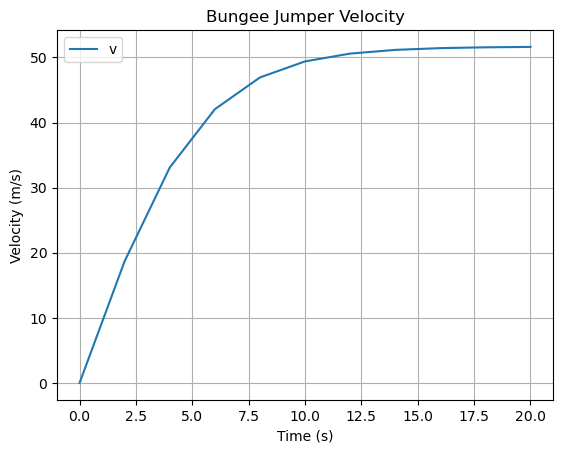

In [3]:
t_ = np.arange(0, bungee_jumper_data['t_final']+bungee_jumper_data['dt'], bungee_jumper_data['dt'])
bungee_jumper_exact_solution = pd.DataFrame(
    data=dict(
        t=t_,
        v=bungee_jumper_velocity(m=bungee_jumper_data['m'], cd=bungee_jumper_data['cd'], t=t_)
    )
)
bungee_jumper_exact_solution.plot(x='t', y='v')
plt.grid()
plt.title('Bungee Jumper Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()

## Using Use Euler Method
In our study case the dependent variable is the velocity $v$ and the independent variable is time $t$ as such:
$$ x \rightarrow v $$
$$ \frac{dv}{dt} = f(v,t) $$
$$ v_{n+1} \approx v_n +  f(v, t) \Delta t $$


In [4]:
from ODE.FirstOrder.FirstOrderODEEulerMethod import FirstOrderODEEulerMethod

euler_solver = FirstOrderODEEulerMethod(
    # f(x,t) -> f(v,t)
    derivative_function=lambda v,t: bungee_jumper_acceleration(m=bungee_jumper_data['m'], cd=bungee_jumper_data['cd'], v=v),
    # v(t=0) = 0
    t0=bungee_jumper_data['t0'],
    x0=bungee_jumper_data['v0'],
    # \Delta t = 2
    dt=bungee_jumper_data['dt'],
    t_final=bungee_jumper_data['t_final'],
)
euler_solver_history_df = euler_solver.run()
clear_output() # clear log messages (uncomment if want to see logs)

In [5]:
euler_solver_history_df.columns = ['$v(t)$', '$t$', r'$\Delta t$', r'$\frac{dv}{dt}$']
euler_solver_history_df[r'$\varepsilon$'] = (euler_solver_history_df['$v(t)$'] - bungee_jumper_exact_solution['v']).abs()
euler_solver_history_df[r'$\varepsilon_r$'] = euler_solver_history_df[r'$\varepsilon$'] / bungee_jumper_exact_solution['v']

# export as tex file
if not Path().cwd() / 'data':
    (Path().cwd() / 'data').mkdir(parents=True, exist_ok=True)
df_to_latex(
    euler_solver_history_df,
    str(Path().cwd() / 'data' / 'EulerMethod_bungeeJumper.tex'),
    formatting={
        '$v(t)$': dict(header='$v(t)$ (m/s)', format='0.6f'),
        '$t$': dict(header='$t$ (s)', format='0.6f'),
        r'$\Delta t$': dict(header=r'$\Delta t$ (s)', format='0.6f'),
        r'$\frac{dv}{dt}$': dict(header=r'$\frac{dv}{dt}$ (m/s$^2$)', format='0.6f'),
        r'$\varepsilon$': dict(header=r'$\varepsilon$ (m/s)', format='0.6f'),
        r'$\varepsilon_r$': dict(header=r'$\varepsilon_r$ (\%)', format=lambda x: f'{x*100:0.6f}' if not pd.isna(x) else r'$\text{-}$'),
    }
)

clear_output()
display(euler_solver_history_df)

,$v(t)$,$t$,$\Delta t$,$\frac{dv}{dt}$,$\varepsilon$,$\varepsilon_r$
0,0.000000,0,2,9.800000,0.000000,NaN
1,19.600000,2,2,9.800000,0.889045,0.047515
2,36.379442,4,2,8.389721,3.296292,0.099637
3,46.262380,6,2,4.941469,4.217731,0.100316
4,50.148666,8,2,1.943143,3.222108,0.068663
5,51.283991,10,2,0.567662,1.892122,0.038308
6,51.573802,12,2,0.144905,0.984603,0.019463
7,51.644749,14,2,0.035473,0.485061,0.009481
8,51.661929,16,2,0.008590,0.232902,0.004529
9,51.666078,18,2,0.002075,0.110440,0.002142


## Using Use Heun Method
In our study case the dependent variable is the velocity $v$ and the independent variable is time $t$ as such:
$$ x \rightarrow v $$
$$ \frac{dv}{dt} = f(v,t) $$
$$ v^{*} \approx v_n +  f(v, t) \Delta t $$
$$ v_{n+1} \approx v_n +  \frac{f(v^{*}, t_n)+f(v, t_n)}{2} \Delta t $$


In [6]:
from ODE.FirstOrder.FirstOrderODEHeunMethod import FirstOrderODEHeunMethod

hun_solver = FirstOrderODEHeunMethod(
    # f(x,t) -> f(v,t)
    derivative_function=lambda v,t: bungee_jumper_acceleration(m=bungee_jumper_data['m'], cd=bungee_jumper_data['cd'], v=v),
    # v(t=0) = 0
    t0=bungee_jumper_data['t0'],
    x0=bungee_jumper_data['v0'],
    # \Delta t = 2
    dt=bungee_jumper_data['dt'],
    t_final=bungee_jumper_data['t_final'],
)

hun_solver_history_df = hun_solver.run()
clear_output() # clear log messages (uncomment if want to see logs)

In [7]:
hun_solver_history_df.columns = ['$v(t)$', '$v^{*}(t)$' , '$t$', r'$\Delta t$', r'$\frac{dv}{dt}$']
hun_solver_history_df[r'$\varepsilon$'] = (hun_solver_history_df['$v(t)$'] - bungee_jumper_exact_solution['v']).abs()
hun_solver_history_df[r'$\varepsilon_r$'] = hun_solver_history_df[r'$\varepsilon$'] / bungee_jumper_exact_solution['v']

# export tex file
df_to_latex(
    hun_solver_history_df,
    str(Path().cwd() / 'data' / 'HeunMethod_bungeeJumper.tex'),
    formatting={
        '$v(t)$': dict(header='$v(t)$ (m/s)', format='0.6f'),
        '$v^{*}(t)$': dict(header='$v^{*}(t)$ (m/s)', format='0.6f'),
        '$t$': dict(header='$t$ (s)', format='0.6f'),
        r'$\Delta t$': dict(header=r'$\Delta t$ (s)', format='0.6f'),
        r'$\frac{dv}{dt}$': dict(header=r'$\frac{dv}{dt}$ (m/s$^2$)', format='0.6f'),
        r'$\varepsilon$': dict(header=r'$\varepsilon$ (m/s)', format='0.6f'),
        r'$\varepsilon_r$': dict(header=r'$\varepsilon_r$ (\%)', format=lambda x: f'{x*100:0.6f}' if not pd.isna(x) else r'$\text{-}$'),
    }
)

clear_output()
display(hun_solver_history_df)

,$v(t)$,$v^{*}(t)$,$t$,$\Delta t$,$\frac{dv}{dt}$,$\varepsilon$,$\varepsilon_r$
0,0.000000,0.000000,0,2,9.800000,0.000000,NaN
1,18.189721,19.600000,2,2,9.800000,0.521234,0.027857
2,31.984920,35.360456,4,2,8.585367,1.098230,0.033196
3,40.698277,44.073649,6,2,6.044364,1.346373,0.032022
4,45.711155,48.137119,8,2,3.719421,1.215403,0.025900
5,48.473864,49.969674,10,2,2.129260,0.918005,0.018586
6,49.965999,50.821915,12,2,1.174025,0.623200,0.012319
7,50.763917,51.235595,14,2,0.634798,0.395771,0.007736
8,51.188447,51.443394,16,2,0.339739,0.240580,0.004678
9,51.413725,51.550142,18,2,0.180848,0.141913,0.002753


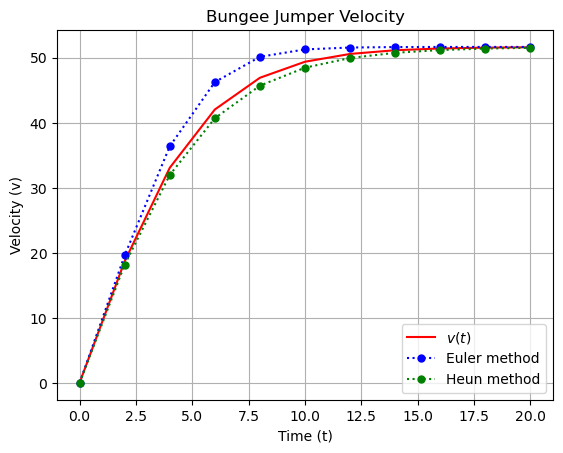

In [8]:
ax = bungee_jumper_exact_solution.plot(x='t', y='v', label='$v(t)$', color='red')
euler_solver_history_df.plot(
    x='$t$', y='$v(t)$', label='Euler method', color='blue', linestyle=':',
    marker='o', markersize=5, ax=ax
)
hun_solver_history_df.plot(
    x='$t$', y='$v(t)$', label='Heun method', color='Green', linestyle=':',
    marker='o', markersize=5, ax=ax
)
plt.xlabel('Time (t)')
plt.ylabel('Velocity (v)')
plt.title('Bungee Jumper Velocity')
plt.grid()
plt.legend()


if not (Path().cwd() / 'figures').exists() :
    (Path().cwd() / 'figures').mkdir(parents=True, exist_ok=True)

plt.savefig(str(Path().cwd() / 'figures' /'Problem1BungeeJumper.png'))

# Problem 2. Case Study: Parachute Drag Coefficient
	A parachute diver with mass $68.1$ kg reached terminal velocity of $40 (m/s)$  on $10$ seconds after jumping from the plane. What is the drag coefficient of the parachute?


In [9]:
import sympy as sp


def parachute_equation(
        c: float,
        m: float,
        t: float,
        v: float,
        g:float = 9.81,
        e:float = np.e
):
    return (m*g/c)*(1-e**(-c*t/m)) - v

parachute_data = dict(
    m = 68.1,
    t = 10.0,
    v = 40.0,
    g = 9.81,
)

## Graphical approch


In [10]:
f_cd = lambda c:parachute_equation(m=parachute_data['m'], t=parachute_data['t'], v=parachute_data['v'], c=c)
c_sym = sp.symbols('c')
e_sym = sp.symbols('e')

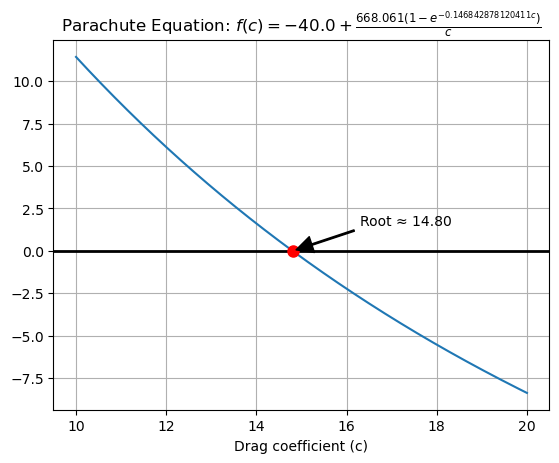

In [11]:
c_ = np.linspace(10,20, 1000)
fc_ = f_cd(c_)
plt.plot(c_, fc_)
plt.axhline(y=0, color='k', linewidth=2.0) # Highlight x-Axis

# Find the root (where fc_ is closest to zero)
root_idx = np.abs(fc_).argmin()
root_c = c_[root_idx]
root_f = fc_[root_idx]
plt.plot(root_c, root_f, 'ro', markersize=8)  # Red circle marker
plt.annotate(f'Root ≈ {root_c:.2f}',
             xy=(root_c, root_f),
             xytext=(root_c+1.5, root_f+1.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             fontsize=10)

plt.xlabel('Drag coefficient (c)')
plt.title(f'Parachute Equation: $f(c)={sp.latex(
    parachute_equation(m=parachute_data['m'], t=parachute_data['t'], v=parachute_data['v'], c=c_sym, e=e_sym))}$')
plt.grid()
plt.savefig(str(Path().cwd() / 'figures' / 'Problem2ParachuteGraphical.png'))

## Bisection Method

In [12]:
from FindRoots.BracketingMethods.BiSectionMethod import BiSectionMethod

bisection_solver = BiSectionMethod(
    function=lambda c:parachute_equation(m=parachute_data['m'], t=parachute_data['t'], v=parachute_data['v'], c=c),
    a=10,
    b=20,
)
bisection_solver_history_df = bisection_solver.run()
clear_output()

TypeError: StopIfEqual.__init__() got an unexpected keyword argument 'tolerance'

In [ ]:
bisection_solver_history_df.columns = ['$c_l$', '$c_u$', '$c$', '$f(c_l)$', '$f(c)$', '$f(c_u)$', '$|c_u-c_l|$', r'log']

df_to_latex(
    bisection_solver_history_df,
    str(Path().cwd() / 'data' / 'BisectionMethod_parachute.tex'),
    formatting={
        '$c_l$': dict(header='$c_l$', format='0.6f'),
        '$c_u$': dict(header='$c_u$', format='0.6f'),
        '$c$': dict(header='$c$', format='0.6f'),
        '$f(c_l)$': dict(header='$f(c_l)$', format='0.6f'),
        '$f(c)$': dict(header='$f(c)$', format='0.6f'),
        '$f(c_u)$': dict(header='$f(c_u)$', format='0.6f'),
        '$|c_u-c_l|$': dict(header='$|c_u-c_l|$', format='0.6f'),
        r'log': dict(header=r'log', format=str),
    }
)

bisection_solver_history_df

## Newton-Raspbian Method
$$ \frac{dx}{dt} = f(x,t) $$
$$ t_{t+1} = t_n - \frac{f(x_n,t_n)}{f'(x_n,t_n)} $$

In [ ]:
from FindRoots.OpenMethods.NewtonRaphsonMethod import NewtonRaphsonMethod
c0 = 10
newton_solver = NewtonRaphsonMethod(
    function=lambda c:parachute_equation(m=parachute_data['m'], t=parachute_data['t'], v=parachute_data['v'], c=c),
    x0=c0,
)
newton_solver_history_df = newton_solver.run()
clear_output()

In [ ]:
newton_solver_history_df.columns = ['$C_d$', '$f(C_d)$', '$f\'(C_d)$']

df_to_latex(
    newton_solver_history_df,
    str(Path().cwd() / 'data' / 'NewtonRaphsonMethod_parachute.tex'),
    formatting={
        '$C_d$': dict(header='$C_d$', format='0.6f'),
        '$f(C_d)$': dict(header='$f(C_d)$', format='0.6f'),
        '$f\'(C_d)': dict(header='$f\'(C_d)$', format='0.6f'),
    }
)
clear_output()
newton_solver_history_df